# AdaBoost
This will load the csv testing and training files into Dataframes

Your Directory should be set up like this:
```
.
│
├── Notebook_Files
│   ├── Data Normalization.ipynb
│   ├── Master Template.ipynb
│   └── Random Forrest.ipynb
├── Source
│   ├── sample_submission.csv
│   ├── test.csv
│   └── train.csv
└── tmdb-box-office-prediction.zip

```

`train_df` - Holds training data

`test_df` - Holds testing data

`orig_df` - Original training data

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection  import  GridSearchCV


train_df = pd.read_csv('../Source/train.csv')
test_df = pd.read_csv("../Source/test.csv")
orig_df = pd.read_csv('../Source/train.csv')


## normalize(df) function
This function needs to be ran on both testing and training data
It takes in a Pandas DataFrame and returns a DataFrame
```
How to use:
df = normalize(df)
```

In [8]:
def encode_list(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    for i in data:
        genre.append(i.get(json_tag))
    return genre

def encode_list_to_count(row, json_tag):
    genre = []
    try:
        data = eval(row)
    except:
        data = {}
    count = 0
    for i in data:
        count += 1
    return count


def normalize(df):
    
    mlb = MultiLabelBinarizer()
    
    ## Count spoken languages 
    df['language_count'] = df['spoken_languages'].apply(lambda x: encode_list_to_count(x, 'iso_639_1'))
    df.pop('spoken_languages')
    
    ## Count Producion COuntry
    df['prod_country_encoded'] = df['production_countries'].apply(lambda x: encode_list(x, 'name'))
    df['produced_in_usa'] = df['prod_country_encoded'].apply(lambda x: 1 if 'United States of America' in x else 0)
    df['prod_country_counted'] = df['production_countries'].apply(lambda x: encode_list_to_count(x, 'name'))
    df.pop('production_countries')
    df.pop('prod_country_encoded')
    
    ## Encode Genre
    df['genre_encoded'] = df['genres'].apply(lambda x: encode_list(x, 'name'))
    df_encoded = pd.DataFrame(mlb.fit_transform(df['genre_encoded']),columns=mlb.classes_, index=df.index)
    df = pd.concat([df,df_encoded], axis=1)
    df.pop('genres')
    df.pop('genre_encoded')
    
    ## Run Time
    df['runtime'] = df['runtime'].replace(np.nan, 0)
    
    ## Crew Count
    df['count_of_crew'] = df['crew'].apply(lambda x: encode_list_to_count(x,'cred_id' ))
    df. pop('crew')

    ## Cast Count
    df['count_of_cast'] = df['cast'].apply(lambda x: encode_list_to_count(x,'cast_id' ))
    df. pop('cast')
    
    ## Production Companies Count
    df['production_companies_count'] = df['production_companies'].apply(lambda x: encode_list_to_count(x,'name' ))
    df. pop('production_companies')
    
    
    ## ENCODE IF ORIGINAL LANGUAGE WAS ENGLISH
    df['orig_lang_is_eng'] = df['original_language'].apply(lambda x: 1 if 'en' in x else 0)
    df.pop('original_language')
    
    ## Cast date to a date type and correct outliers
    current_year = pd.Timestamp(year=2023, month=1, day=1, hour=0, minute=0, second=0)
    df['date'] = pd.to_datetime(df['release_date'])
    df['date'] = df['date'].apply(lambda x: x - pd.DateOffset(years=100) if x > current_year else x)
    df.pop('release_date')
    
    ## Create release month int value
    df['release_month'] = df["date"].dt.month
    df.pop('date')  ## You can remove this if you want to used the date somehow
    
    ## Encode Collection status 
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: encode_list_to_count(x, 'name'))
    
    # drop irrelevant/unused columns
    df.pop('tagline')
    df.pop('Keywords')
    df.pop('overview')
    df.pop('id')
    df.pop('belongs_to_collection')
    df.pop('homepage')
    df.pop('imdb_id')
    df.pop('original_title')
    df.pop('poster_path')
    df.pop('title')
    df.pop('status')
    
    return df

### Normalize Train and Test data

In [9]:

train_df = normalize(train_df)
test_df = normalize(test_df)

### Adding average to budget values of 0

In [10]:
# var holding total budget
total_budget = 0
count = 0

# for loop traversing budget
for entry in train_df['budget']:
    total_budget += entry
    if entry != 0:
        count += 1
    
# finding average and adding it to entries with 0 value
budget_avg = total_budget / count
train_df.loc[train_df['budget'] == 0, 'budget'] = budget_avg
train_df[:5]

,budget,popularity,runtime,revenue,language_count,produced_in_usa,prod_country_counted,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,count_of_crew,count_of_cast,production_companies_count,orig_lang_is_eng,release_month
0,1.400000e+07,6.575393,93.0,12314651,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,72,24,3,1,2
1,4.000000e+07,8.248895,113.0,95149435,1,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,9,20,1,1,8
2,3.300000e+06,64.299990,105.0,13092000,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,64,51,3,1,10
3,1.200000e+06,3.174936,122.0,16000000,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,3,7,0,0,3
4,3.089305e+07,1.148070,118.0,3923970,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,4,0,0,2


In [11]:
# import tool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# split data
feature_cols = list(train_df.columns)
feature_cols.remove('revenue')
X = train_df[feature_cols]
y = train_df['revenue']

# scale feature data
X = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# check size of sets
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(2100, 31)
(900, 31)
(2100,)
(900,)


## GridSearch for best parameters
AdaBoostRegressor(learning_rate=0.001, n_estimators=100)

In [12]:
# import tools
from sklearn.model_selection import GridSearchCV

# dictionary with parameters to test
params = {'n_estimators': [100, 200, 500, 750, 1000],
              'learning_rate': [0.01, 0.001, 0.0001],}

# create regressor
regressor = AdaBoostRegressor(random_state=2)

# create grid
xgb_grid = GridSearchCV(regressor,
                        params,
                        cv = 10,
                        scoring='r2',
                        verbose=10)

# fit the grid
xgb_grid.fit(X_train, y_train)

# see results
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV 1/10; 1/15] START learning_rate=0.01, n_estimators=100......................
[CV 1/10; 1/15] END learning_rate=0.01, n_estimators=100;, score=0.529 total time=   0.3s
[CV 2/10; 1/15] START learning_rate=0.01, n_estimators=100......................
[CV 2/10; 1/15] END learning_rate=0.01, n_estimators=100;, score=0.627 total time=   0.3s
[CV 3/10; 1/15] START learning_rate=0.01, n_estimators=100......................
[CV 3/10; 1/15] END learning_rate=0.01, n_estimators=100;, score=0.692 total time=   0.3s
[CV 4/10; 1/15] START learning_rate=0.01, n_estimators=100......................
[CV 4/10; 1/15] END learning_rate=0.01, n_estimators=100;, score=0.501 total time=   0.3s
[CV 5/10; 1/15] START learning_rate=0.01, n_estimators=100......................
[CV 5/10; 1/15] END learning_rate=0.01, n_estimators=100;, score=0.728 total time=   0.3s
[CV 6/10; 1/15] START learning_rate=0.01, n_estimators=100......................
[

KeyboardInterrupt: 

In [13]:
Ada_regressor = AdaBoostRegressor(learning_rate=0.001, n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, random_state=4)

In [14]:
AdaBoost_R = Ada_regressor.fit(X_train, y_train)

In [15]:
y_pred = AdaBoost_R.predict(X_test)

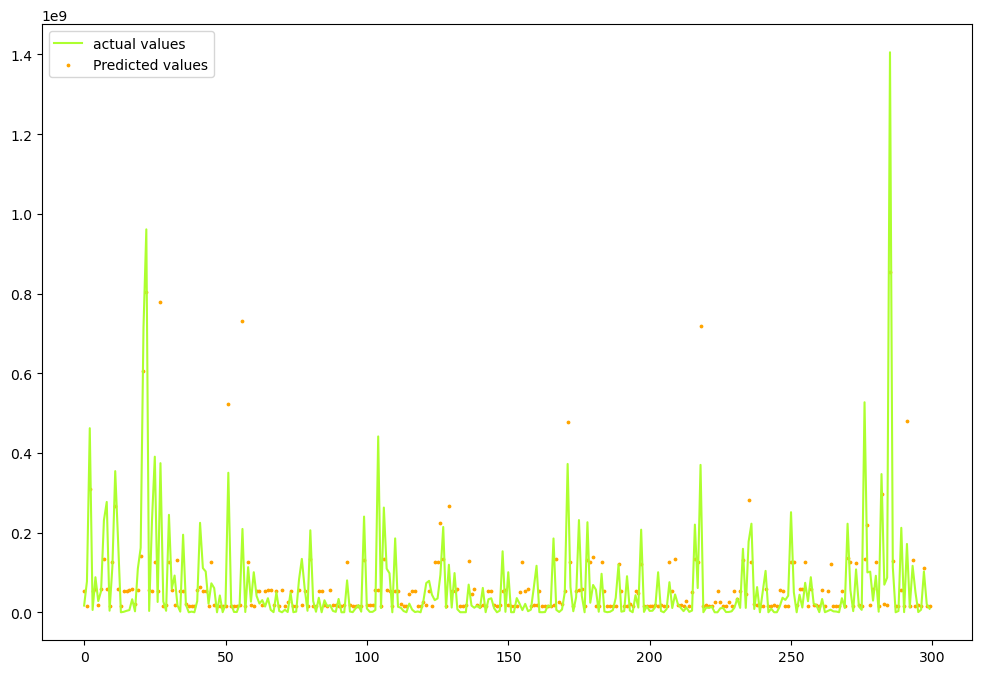

r2_score: 0.589910175497272 
 RMSE: 86.23531262131694 in millions 



In [16]:
#  fitting the size of the plot
plt.figure(figsize=(12, 8))

# plotting the graph for the actual values
plt.plot([i for i in range(len(y_test))],y_test, label="actual values", c='greenyellow')

# plotting the graph for predictions
plt.scatter([i for i in range(len(y_test))],y_pred, label="Predicted values", c='orange', s=3)

plt.legend()
plt.show()
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_pred)
print( f"r2_score: {r2} \n RMSE: {rmse / float(1000000)} in millions \n")

## AdaBoost with scaling

In [21]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(pd.DataFrame(y))

### Averaging Results across 100  Train Test Splits

In [23]:
from sklearn.tree import DecisionTreeRegressor
# import tool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# split data
train_df = pd.read_csv('../Source/train.csv')
train_df = normalize(train_df)
feature_cols = list(train_df.columns)
feature_cols.remove('revenue')
X = train_df[feature_cols]
y = train_df['revenue']

regr = DecisionTreeRegressor(max_depth=5)
r2_average = 0;
rmse_average = 0;
number_of_loops = 100

for j in range(0,number_of_loops):
    sc_X = StandardScaler()
    sc_y = StandardScaler()
    X_loop = sc_X.fit_transform(X)
    y_loop = sc_y.fit_transform(pd.DataFrame(y))
    X_train, X_test, y_train, y_test = train_test_split(X_loop, y_loop, test_size=.10, random_state=j)
    model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4, random_state=2),learning_rate=0.001, n_estimators=100)
    model.fit(X_train,y_train.ravel())
    #  Commented out 
    #  fitting the size of the plot
    #plt.figure(figsize=(12, 8))
    #plt.title(f"ADABoost\nRandom State {j}")
    #plt.yticks([1000000,100000000, 1000000000], ['1 Million', '100 Million', '1 Billion' ])


    y_pred = model.predict(X_test)
    y_pred = sc_y.inverse_transform(pd.DataFrame(y_pred)) 
    y_test = sc_y.inverse_transform(pd.DataFrame(y_test)) 

    # Draw line for 0 values
    #plt.axhline(y=0, linestyle='dotted')

    # plotting the graph for the actual values
    #plt.plot([i for i in range(len(y_test))],y_test, label="actual values", c='greenyellow')

    # plotting the graph for predictions
    #plt.plot([i for i in range(len(y_test))],y_pred, label="Predicted values", c='orange', alpha=0.75)#, s=5)

    
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,y_pred)
    r2_average += r2
    rmse_average += rmse
    print( f"R2: {r2} RMSE: {rmse/1000000}\n j = {j}")
    #plt.legend(title=f"r2_score:  {r2:.3f}\nRMSE:  {rmse/1000000:.2f} million")
    #plt.savefig(f"./Plots/ADA_Boost_{j}.png")
print(f"\n R2 average: {r2_average/number_of_loops}\n RMSE Average: {(rmse_average/number_of_loops)/1000000}")

#plt.show()


R2: 0.7116848993477852 RMSE: 80.40942156405978
 j = 0
R2: 0.5655316398710688 RMSE: 81.47194379247516
 j = 1
R2: 0.4544134785819599 RMSE: 84.16371465598769
 j = 2
R2: 0.57431592188303 RMSE: 85.22906920347556
 j = 3
R2: 0.6630422719484919 RMSE: 78.16878399849203
 j = 4
R2: 0.5554480105146175 RMSE: 64.6657295613259
 j = 5
R2: 0.6666115791544391 RMSE: 97.95857917177524
 j = 6
R2: 0.6554280007444637 RMSE: 88.11458959393059
 j = 7
R2: 0.7049322035485719 RMSE: 74.366745219767
 j = 8
R2: 0.6902031935228983 RMSE: 66.05995439087532
 j = 9
R2: 0.6752591281272854 RMSE: 82.33895962549838
 j = 10
R2: 0.5330209753080842 RMSE: 88.86552522693135
 j = 11
R2: 0.7508466160642586 RMSE: 59.003507063430874
 j = 12
R2: 0.39602177950616035 RMSE: 81.07213277778477
 j = 13
R2: 0.6680303564426691 RMSE: 88.90508958113715
 j = 14
R2: 0.6275093232502678 RMSE: 88.25459752822451
 j = 15
R2: 0.6751321432432402 RMSE: 94.03354440235081
 j = 16
R2: 0.6652800432913681 RMSE: 86.0703327441318
 j = 17
R2: 0.5608895645893064 R